In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import ease

In [48]:
def rf(prec, ts, tw, ws):
    """
    This function is RandomForest classifier to intake user input temperature,
    precipitation, and windespeed to classify the possible states the user
    will be in, and returns a dictionary with states as the keys and
    the frequency or count as the values of each key.
       input = user input values, integer or float based.
       vote  = dictionary based output that contains the RF classified states,
               and each states frequency.
    """
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    import itertools as it
    import warnings

    train = pd.read_csv('../Arranged_Data/final_weater.csv')[[
            'State', 'TotalMonthlyPrecip', 'TempSummer',
            'TempWinter', 'Avgwindspeed']]
    train = train[train.State != 'DC']

    warnings.filterwarnings('ignore')

    input_ = [prec, ts, tw, ws]
    tree_num = 5000
    pred_list = []
    vote = {}
    rf = RandomForestClassifier(n_estimators = tree_num)
    rf.fit(train.iloc[:,1:5], train.State)

    for i in range(tree_num):
        dt = rf.estimators_[i]
        dt.fit(train.iloc[:,1:5], train.State)
        pred = dt.predict(input_)
        pred_list.append(pred[0])

    pred_key = []
    pred_key_count = []
    for key, group in it.groupby(sorted(pred_list)):
        pred_key.append(key)
        pred_key_count.append(len(list(group)))

    for i in range(len(pred_key)):
        vote[pred_key[i]] = pred_key_count[i]/tree_num
    return vote

In [3]:
def avg_capacity(vote):
    import pandas as pd
    average_plant_capacity = pd.read_csv('../Arranged_Data/average_plant_capacity.csv')
    avg_cap_list = []
    coal_sum = 0
    ng_sum = 0
    petro_sum = 0
    hydro_sum = 0
    solar_sum = 0
    wind_sum =0
    for i in vote.keys():
        coal_sum += int(average_plant_capacity.Coal[average_plant_capacity.State == i]) * vote[i]
        ng_sum += int(average_plant_capacity.NG[average_plant_capacity.State == i]) * vote[i]
        petro_sum += int(average_plant_capacity.Petro[average_plant_capacity.State == i]) * vote[i]
        hydro_sum += int(average_plant_capacity.Hydro[average_plant_capacity.State == i]) * vote[i]
        solar_sum += int(average_plant_capacity.Solar[average_plant_capacity.State == i]) * vote[i]
        wind_sum += int(average_plant_capacity.Wind[average_plant_capacity.State == i]) * vote[i]
    return([coal_sum, ng_sum, petro_sum, hydro_sum, solar_sum, wind_sum])

In [4]:
cap_pop = pd.read_csv('../Arranged_Data/average_plant_capacity.csv')
cap_pop[cap_pop.Coal != 0].Coal.mean()

1439076.4893617022

In [6]:
def possible_type(avg_cap_list):
    import pandas as pd
    from scipy import stats
    cap_pop = pd.read_csv('../Arranged_Data/average_plant_capacity.csv')
    e_type = ['Coal', 'NG', 'Petro', 'Hydro', 'Solar', 'Wind']
    possible_type_list = []
    for i in range(len(e_type)):
        p_value = stats.ttest_1samp(cap_pop[cap_pop[e_type[i]] != 0][e_type[i]], avg_cap_list[i])[1]
        alpha = 0.05  #confidence
        if avg_cap_list[i] < cap_pop[cap_pop[e_type[i]] !=0][e_type[i]].mean():
            if p_value < alpha:
                pass
            else:
                p_value = -(1 - p_value)
                possible_type_list.append([p_value, avg_cap_list[i], e_type[i]])
        else:
            p_value = (1 - p_value)
            possible_type_list.append([p_value, avg_cap_list[i], e_type[i]])
    return possible_type_list

In [7]:
possible_type([3427272.05, 601160.0700000001, 132529.37000000002, 159063.21, 2253.23, 149414.79999999996])

[[1.0, 3427272.05, 'Coal'],
 [0.9999957284484875, 601160.0700000001, 'NG'],
 [0.99999999999991029, 132529.37000000002, 'Petro'],
 [0.71925414999001624, 159063.21, 'Hydro'],
 [-0.94810332639059414, 2253.23, 'Solar'],
 [0.99999976119956313, 149414.79999999996, 'Wind']]

In [49]:
#test 5000 DT output fluctuation:
def rf_fluctuation(prec, ts, tw, ws):
    max_keys = []
    max_values =[]
    for i in range(10):
        i = rf(prec, ts, tw, ws)
        max_i_value = max(i.values())
        max_key = max(i.keys(), key=(lambda k: i[k]))
        max_values.append(max_i_value)
        max_keys.append(max_key)
    return (max_values, np.std(max_values), max_keys)

rf_fluctuation(2, 75, 50, 1.5)

([0.4222,
  0.4324,
  0.427,
  0.4244,
  0.4336,
  0.425,
  0.4306,
  0.4186,
  0.4172,
  0.4146],
 0.006166879275614193,
 ['GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA'])

In [40]:
a = ease.avg_capacity(ease.rf(2, 75, 30, 1.5))
a

[2120699.11,
 333367.88,
 69732.54000000001,
 77103.64,
 896.4799999999999,
 84958.84000000001]

In [10]:
b = ease.possible_type(a)

In [12]:
def rev_plot(avg_cost, capacity, e_type, label, avg_cost_conv = 0, capacity_conv = 0):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    esales = pd.read_csv('../Arranged_Data/Cost/Sale_CO2_tax.csv', skiprows= 1, names = ['Year', 'Sale', 'CO2_tax'])
    if e_type == 'conventional':
        revenue = (esales.Sale - esales.CO2_tax - avg_cost) * capacity / 1e6
    elif e_type == 'clean':
        revenue = (esales.Sale - avg_cost) * capacity / 1e6
    elif e_type == 'total':
        revenue = ((esales.Sale - avg_cost) * capacity + (esales.Sale - esales.CO2_tax - avg_cost_conv) * capacity_conv) / 1e6
    plt.plot(np.arange(2018, 2051), revenue[3:], label=label)
    plt.xlabel('Year')
    plt.ylabel('Money Save (million dollars / year)')
    plt.legend()
    plt.grid()
    return plt

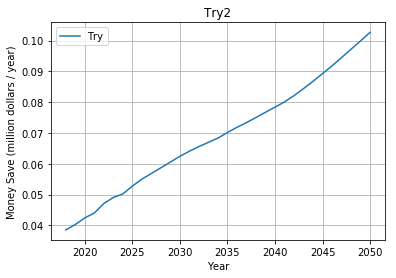

In [13]:
a = rev_plot(30, 500, 'total', 'Try', 10, 3)
a.title('Try2')

In [14]:
np.array(b)[:, 2]

array(['Coal', 'NG', 'Petro', 'Hydro', 'Wind'], 
      dtype='<U32')

In [15]:
def avg_cost(vote):
    import pandas as pd
    cost = pd.read_csv('../Arranged_Data/Cost/df_cost.csv')
    coal_sum = 0
    ng_sum = 0
    petro_sum = 0
    hydro_sum = 0
    solar_sum = 0
    wind_sum =0
    for i in vote.keys():
        coal_sum += int(cost.Coal[cost.State == i]) * vote[i]
        ng_sum += int(cost.NG[cost.State == i]) * vote[i]
        petro_sum += int(cost.Petro[cost.State == i]) * vote[i]
        hydro_sum += int(cost.Hydro[cost.State == i]) * vote[i]
        solar_sum += int(cost.solar[cost.State == i]) * vote[i]
        wind_sum += int(cost.WindCost[cost.State == i]) * vote[i]
    avg_cost_dict = {'Coal':coal_sum, 'NG':ng_sum, 'Petro':petro_sum, 'Hydro':hydro_sum, 'Solar':solar_sum, 'Wind':wind_sum}
    return avg_cost_dict

In [16]:
avg_cost(ease.rf(2, 75, 30, 1.5))

{'Coal': 25.15,
 'Hydro': 84.99999999999999,
 'NG': 52.029999999999994,
 'Petro': 166.75,
 'Solar': 129.33999999999997,
 'Wind': 37.02}

In [17]:
def clean_or_conv(possible_type_list):
    clean_list = []
    conventional_list = []
    for i in possible_type_list:
        if i[2] == 'Coal' or i[2] == 'NG' or i[2] == 'Petro':
            conventional_list.append(i)
        elif i[2] == 'Hydro' or i[2] == 'Solar' or i[2] == 'Wind':
            clean_list.append(i)
    return conventional_list, clean_list

In [18]:
conv, clean = clean_or_conv([[0.95810457341493549, 3427272.05, 'Coal'],
 [-0.8923811497455455, 601160.0700000001, 'NG'],
 [0.99926594657247059, 132529.37000000002, 'Petro'],
 [-0.90421357886564524, 159063.21, 'Hydro'],
 [-0.83811357367028649, 149414.79999999996, 'Wind']])
clean

[[-0.9042135788656452, 159063.21, 'Hydro'],
 [-0.8381135736702865, 149414.79999999996, 'Wind']]

In [19]:
def sort_and_pick(source_list):
    source_list.sort()
    if len(source_list) == 3:
        ref = source_list[2]
        if abs(source_list[2][0] - source_list[1][0]) < 0.05 and abs(source_list[1][0] - source_list[0][0]) < 0.05 :
            for i in source_list:
                if i[1] > ref[1]:
                    ref = i
        elif abs(source_list[2][0] - source_list[1][0]) < 0.05 and abs(source_list[1][0] - source_list[0][0]) >= 0.05:
            if source_list[1][1] > ref[1]:
                ref = source_list[1]
    elif len(source_list) == 2:
        ref = source_list[1]
        if abs(source_list[1][0] - source_list[0][0]) < 0.05 :
            if source_list[0][1] > ref[1]:
                ref = source_list[0]
    elif len(source_list) == 1:
        ref = source_list[0]
    else:
        ref = []
    return ref

In [20]:
def suggest(prec, ts, tw, ws, capacity):
    state_vote = rf(prec, ts, tw, ws)
    cap = avg_capacity(state_vote)
    cost = avg_cost(state_vote)
    source_list = possible_type(cap)
    conventional, clean = clean_or_conv(source_list)
    conventional = sort_and_pick(conventional)
    clean = sort_and_pick(clean)
    if len(clean) == 0:
        capacity = min([conventional[1], capacity])
        revenue_clean = None
        revenue_conv = rev_plot(cost[conventional[2]], capacity, 'conventional', conventional[2])
        revenue_conv.title('Money Save using ' + conventional[2] + ' (capacity = ' + str(capacity) + ' Mwh)')
        revenue_total = None
    else:
        if clean[1] >= capacity:
            revenue_clean = rev_plot(cost[clean[2]], capacity, 'clean', clean[2])
            revenue_clean.title('Money Save using ' + clean[2] + ' (capacity = ' + str(capacity) + ' Mwh)')
            revenue_conv = None
            revenue_total = None
        else:
            revenue_clean = rev_plot(cost[clean[2]], clean[1], 'clean', clean[2] + ' (capacity = ' + str(int(clean[1])) + ' Mwh)')
            revenue_conv = rev_plot(cost[conventional[2]], (capacity - clean[1]), 'conventional', conventional[2] + ' (capacity = ' + str(int(capacity - clean[1])) + ' Mwh)')
            revenue_total = rev_plot(cost[clean[2]], clean[1], 'total', 'Total (capacity = ' + str(capacity) + ' Mwh)', avg_cost_conv = cost[conventional[2]], capacity_conv = (capacity - clean[1]))
            revenue_total.title('Money Save using ' + clean[2] + ' Combined with ' + conventional[2])
    return revenue_clean, revenue_conv, revenue_total

(<module 'matplotlib.pyplot' from '/Users/IvanC/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/IvanC/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/IvanC/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>)

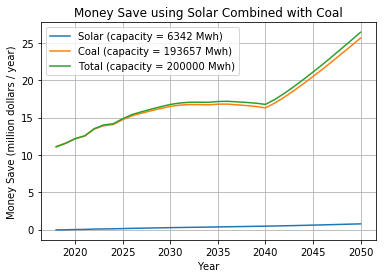

In [29]:
suggest(2, 75, 50, 1.5, 200000)

In [34]:
def suggest(prec, ts, tw, ws, capacity):
    total_co2 = pd.read_csv('../Original_Data/Carbon_dioxide_emission/US_CO2_emission.csv').rename(columns = {'CO2_emission (Metric Tons)':'CO2'})
    source_co2 = {'Coal':1364, 'Petro':24, 'NG':530}
    state_vote = rf(prec, ts, tw, ws)
    cap = avg_capacity(state_vote)
    cost = avg_cost(state_vote)
    source_list = possible_type(cap)
    conventional, clean = clean_or_conv(source_list)
    conventional = sort_and_pick(conventional)
    clean = sort_and_pick(clean)
    if len(clean) == 0:
        capacity = min([conventional[1], capacity])
        revenue_clean = None
        revenue_conv = rev_plot(cost[conventional[2]], capacity, 'conventional', conventional[2])
        revenue_conv.title('Money Save using ' + conventional[2] + ' (capacity = ' + str(capacity) + ' Mwh)')
        revenue_total = None
    else:
        if clean[1] >= capacity:
            revenue_clean = rev_plot(cost[clean[2]], capacity, 'clean', clean[2])
            revenue_clean.title('Money Save using ' + clean[2] + ' (capacity = ' + str(capacity) + ' Mwh)')
            revenue_conv = None
            revenue_total = None
        else:
            revenue_clean = rev_plot(cost[clean[2]], clean[1], 'clean', clean[2] + ' (capacity = ' + str(int(clean[1])) + ' Mwh)')
            revenue_conv = rev_plot(cost[conventional[2]], (capacity - clean[1]), 'conventional', conventional[2] + ' (capacity = ' + str(int(capacity - clean[1])) + ' Mwh)')
            revenue_total = rev_plot(cost[clean[2]], clean[1], 'total', 'Total (capacity = ' + str(capacity) + ' Mwh)', avg_cost_conv = cost[conventional[2]], capacity_conv = (capacity - clean[1]))
            revenue_total.title('Money Save using ' + clean[2] + ' Combined with ' + conventional[2])
            co2_emission = 
    return revenue_clean, revenue_conv, revenue_total


#sub_in = 193657
#plt.bar(total_co2.Year, total_co2.CO2)

193140.79


(<module 'matplotlib.pyplot' from '/Users/IvanC/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/IvanC/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/IvanC/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>)

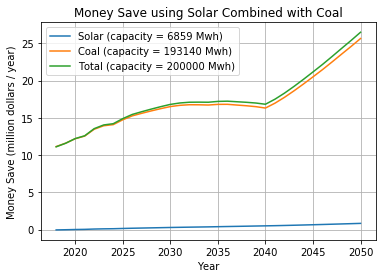

<Container object of 11 artists>

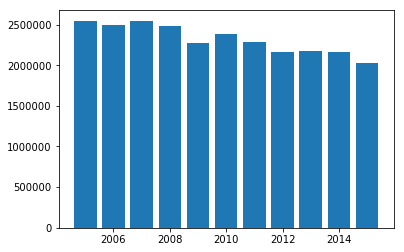

In [50]:
total_co2 = pd.read_csv('../Original_Data/Carbon_dioxide_emission/US_CO2_emission.csv').rename(columns = {'CO2_emission (Metric Tons)':'CO2'})
source_co2 = {'Coal':1364, 'Petro':24, 'NG':530}
plt.bar(total_co2.Year, total_co2.CO2)